In [18]:
import os
import copy
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import h5py
from sklearn.preprocessing import StandardScaler
from scipy.optimize import least_squares

np.random.seed(0)


Globals

In [19]:
IN_ROWS = 100
IN_COLS = 160
OUT_ROWS = 48
OUT_COLS = 48
IMG_COL_BITWIDTH = int(np.ceil(np.log2(IN_COLS+1))+1)
IMG_ROW_BITWIDTH = int(np.ceil(np.log2(IN_ROWS+1))+1)
NUM_CROPS = 1

TESTBENCH_TYPE = "VALUE_EQUALS_INDEX"
assert(TESTBENCH_TYPE in ["VALUE_EQUALS_INDEX"]) # ["REAL_DATA", "VALUE_EQUALS_INDEX", "RANDOM"])
if TESTBENCH_TYPE=="VALUE_EQUALS_INDEX":
    FP_FRAC = 0 # We just want integer values corresponding to the index of each pixel
    FP_INT = 15 # int(np.log2(IN_ROWS*IN_COLS)) + 1 
    FP_TOTAL = FP_FRAC + FP_INT + 1 # We'll keep it signed for simplicity
    DATA_STRING_INSERT = "_INDEX"
    VMAX = IN_ROWS*IN_COLS
elif TESTBENCH_TYPE=="REAL_DATA":
    FP_FRAC = 13
    FP_INT = 2
    FP_TOTAL = FP_FRAC + FP_INT + 1
    DATA_STRING_INSERT = ""
    VMAX = 1
elif TESTBENCH_TYPE=="RANDOM":
    FP_FRAC = 13
    FP_INT = 2
    FP_TOTAL = FP_FRAC + FP_INT + 1
    DATA_STRING_INSERT = "_RANDOM"
    VMAX = 1
else: raise NotImplementedError

SMALL_MODEL = True
if SMALL_MODEL:
    MODEL_STRING_INSERT = "_SMALL"
else:
    MODEL_STRING_INSERT = ""

REUSE_FACTOR = 32

print(f"IMG_COL_BITWIDTH: {IMG_COL_BITWIDTH}")
print(f"IMG_ROW_BITWIDTH: {IMG_ROW_BITWIDTH}")
print(f"FP_TOTAL: {FP_TOTAL}")
print(f"FP_INT: {FP_INT}")
print(f"FP_FRAC: {FP_FRAC}")
print(f"MODEL_STRING_INSERT: {MODEL_STRING_INSERT}")
print(f"DATA_STRING_INSERT: {DATA_STRING_INSERT}")


top_level_dir = os.path.join("tb_data", f"ap_fixed_{FP_TOTAL}_{FP_INT}", f"{IN_ROWS}x{IN_COLS}_to_{OUT_ROWS}x{OUT_COLS}x{NUM_CROPS}")
os.makedirs(top_level_dir, exist_ok=True)

IMG_COL_BITWIDTH: 9
IMG_ROW_BITWIDTH: 8
FP_TOTAL: 16
FP_INT: 15
FP_FRAC: 0
MODEL_STRING_INSERT: _SMALL
DATA_STRING_INSERT: _INDEX


Helper functions

In [20]:
def float_to_fixed_point(value: float, total_bits: int, fractional_bits: int) -> str:
    """
    Convert a float to a fixed-point binary representation.
    
    :param value: Float value to convert.
    :param total_bits: Total number of bits for the representation.
    :param fractional_bits: Number of fractional bits.
    :return: Fixed-point binary string.
    """
    scale = 2 ** fractional_bits
    fixed_point_value = int(round(value * scale))
    
    # Handle two's complement representation for negative numbers
    if fixed_point_value < 0:
        fixed_point_value = (1 << total_bits) + fixed_point_value
    
    return f"{fixed_point_value:0{total_bits}b}"


def fixed_point_to_float(binary: str, fractional_bits: int) -> float:
    """
    Convert a fixed-point binary representation to a float.
    
    :param binary: Fixed-point binary string.
    :param fractional_bits: Number of fractional bits.
    :return: Float value.
    """
    total_bits = len(binary)
    int_value = int(binary, 2)
    
    # Handle two's complement for negative numbers
    if int_value >= (1 << (total_bits - 1)):
        int_value -= (1 << total_bits)
    
    return int_value / (2 ** fractional_bits)

# 1. Generate, save testbench data

First, the un-cropped image

In [21]:
img_precrop_float = np.array([i for i in range(IN_ROWS*IN_COLS)]).reshape((IN_ROWS, IN_COLS)).astype(np.float32)
fpath_img_precrop = os.path.join(top_level_dir, f"img_precrop{DATA_STRING_INSERT}.bin")
with open(fpath_img_precrop, "w") as f:
    for row in img_precrop_float:
        for val in row:
            val_fixed = float_to_fixed_point(val, FP_TOTAL, FP_FRAC)
            f.write(f"{val_fixed}\n")

Now, iterate through some possible crops, including all corners and some edges, and save each one

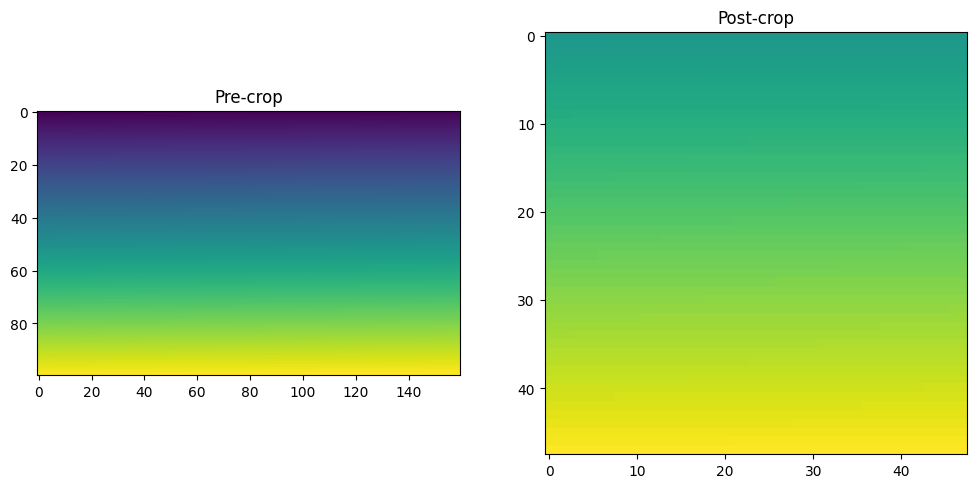

In [25]:
Y1_range = [0, 37, IN_ROWS-OUT_ROWS]
X1_range = [0, 59, IN_COLS-OUT_COLS]

for Y1 in Y1_range:
    Y2 = Y1+OUT_ROWS
    for X1 in X1_range:
        X2 = X1+OUT_COLS

        img_postcrop_float = img_precrop_float[Y1:Y2, X1:X2].astype(np.float32)
        fpath_img_postcrop = os.path.join(top_level_dir, f"Y1_{Y1}", f"X1_{X1}", f"img_postcrop{DATA_STRING_INSERT}.bin")
        os.makedirs(os.path.dirname(fpath_img_postcrop), exist_ok=True)
        with open(fpath_img_postcrop, "w") as f:
            for row in img_postcrop_float:
                for val in row:
                    val_fixed = float_to_fixed_point(val, FP_TOTAL, FP_FRAC)
                    f.write(f"{val_fixed}\n")

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.imshow(img_precrop_float, vmin=0, vmax=IN_ROWS*IN_COLS)
ax1.set_title("Pre-crop")
ax2.imshow(img_postcrop_float, vmin=0, vmax=IN_ROWS*IN_COLS)
ax2.set_title("Post-crop")
plt.show(fig)
plt.close(fig)